# (02) Z traversal

**Motivation**: Debug z traversal.

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from analysis.linear import mi_analysis

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

## Load

In [3]:
# skip + x
# model_name = 'fixate1_k-32_z-20x[3,6,12]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)'
# fit_name = 'ep160-b600-lr(0.002)_beta(0.15:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_04_24,18:00)'

# skip + 0.1 * x
model_name = 'fixate1_k-32_z-14x[5,10,20]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)'
fit_name = 'skip+0.1x_ep160-b600-lr(0.002)_beta(0.15:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_05_30,09:01)'

tr, meta = load_model(
    model_name=model_name,
    fit_name=fit_name,
    verbose=True,
    device='cpu',
)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  39.3 Mil  |
|     ---      |    ---     |
|     stem     |    320     |
| pre_process  |   96.0 K   |
|  enc_tower   |  22.5 Mil  |
|     enc0     |   66.0 K   |
| enc_sampler  |  3.0 Mil   |
| dec_sampler  |  3.0 Mil   |
|    expand    |  287.1 K   |
|  dec_tower   |  10.3 Mil  |
| post_process |   40.0 K   |
|     out      |    578     |
+--------------+------------+

# params: 39.3 M

## Estimate prior $\mu, \sigma$

In [4]:
%%time
x_sample, z_sample = tr.sample(int(1e6))

CPU times: user 6h 20min 36s, sys: 16min 58s, total: 6h 37min 35s
Wall time: 15min 30s


In [5]:
scales, lvl_ids = tr.model.latent_scales()
plot_latents_hist(z_sample, scales);
plot_latents_hist_full(z_sample, scales);

In [6]:
zmu = z_sample.mean(0)
zsd = z_sample.std(0)

In [7]:
fig, axes = create_figure(1, 3, (9, 2), layout='constrained')
sns.histplot(zmu, kde=True, color='k', label=r'$\mu$', ax=axes[0])
sns.histplot(zsd, kde=True, color='k', label=r'$\sigma$', ax=axes[1])
sns.histplot(zmu / zsd, kde=True, color='C0', label=r'$\mu\,/\,\sigma$', ax=axes[2])
axes[1].set_ylabel('')
axes[2].set_ylabel('')
for ax in axes.flat:
    ax.legend()
plt.show()

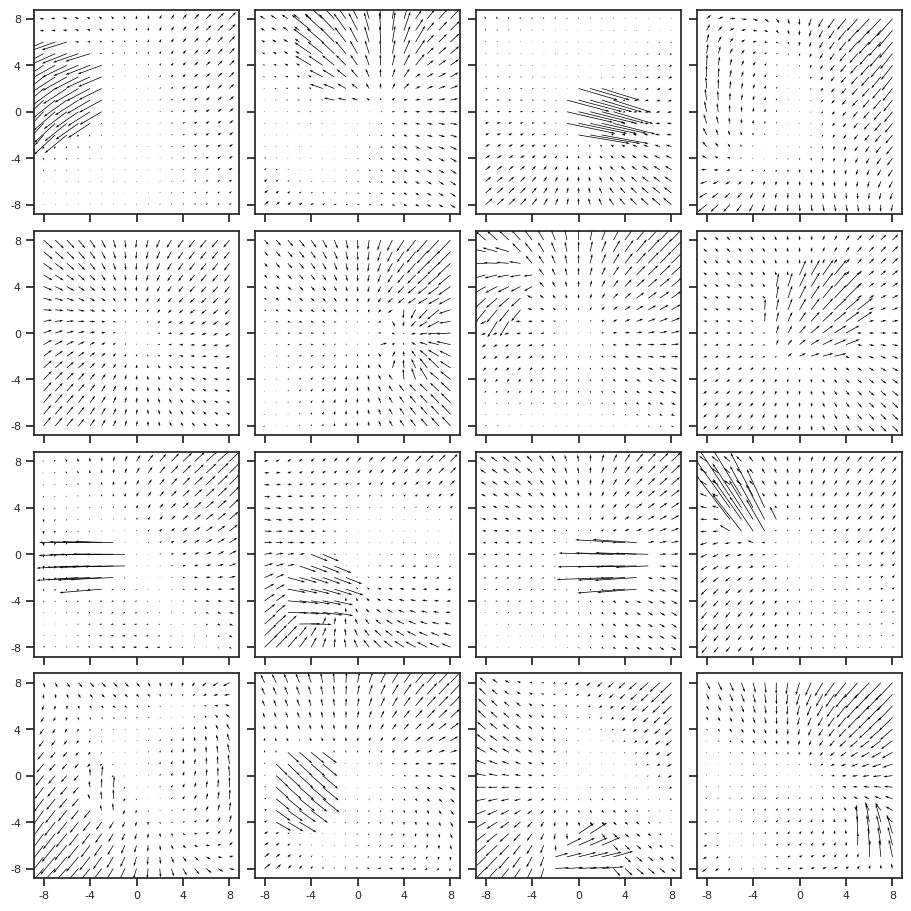

In [8]:
fig, axes = show_opticflow(x_sample)

## Traverse

### Get some random samples

In [9]:
x, _ = next(iter(tr.dl_trn))
fig, _ = show_opticflow(x)

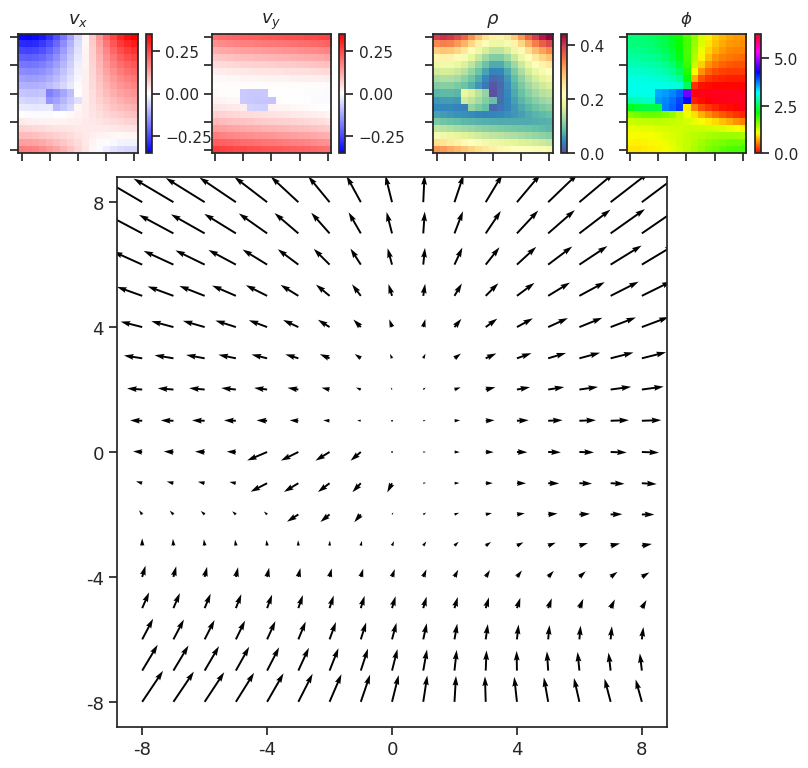

In [10]:
which_sample = 7
show_opticflow_full(x[which_sample]);

### Check recon quality

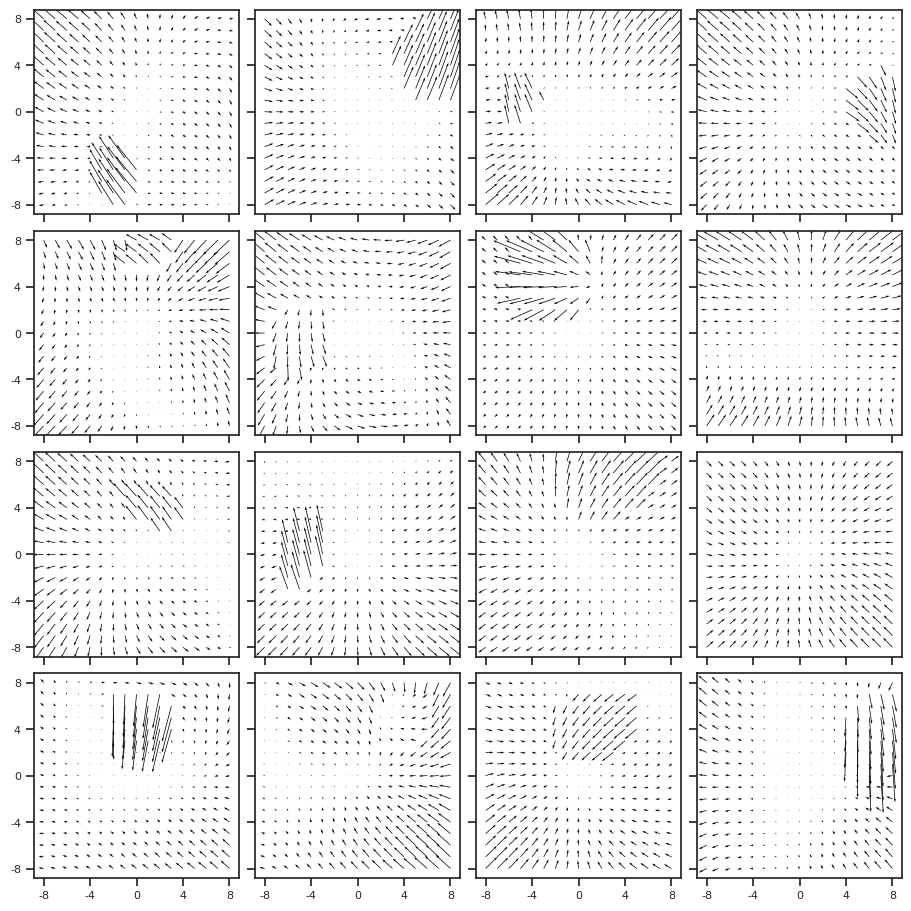

In [11]:
with torch.no_grad():
    x_hat, z, q, p = tr.model(x)
fig, _ = show_opticflow(x_hat)

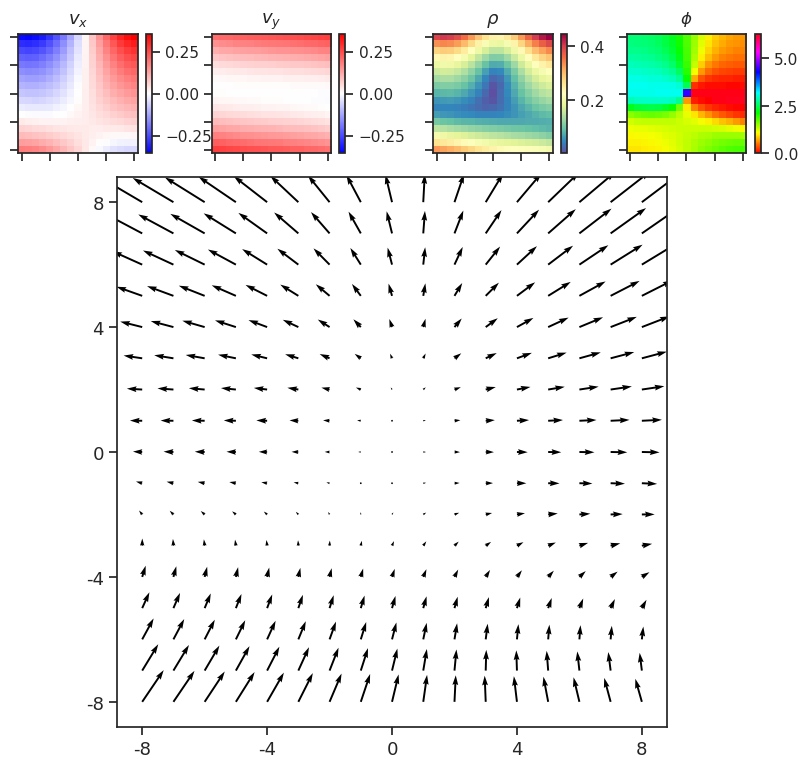

In [12]:
show_opticflow_full(x_hat[which_sample]);

## Interpolate + generate

In [13]:
n = 16
start_i, end_i = 0, 10
z_interp = [interp(e[start_i], e[end_i], n) for e in z]

In [14]:
x_interp = tr.model.generate(z_interp)
fig, _ = show_opticflow(x_interp)

## Traverse + generate

In [15]:
nz = tr.model.cfg.n_latent_per_group
n_groups = sum(tr.model.cfg.groups)
nz, n_groups, nz * n_groups

(14, 35, 490)

In [19]:
i = 86
group_i, latent_i = i // nz, i % nz
group_i, latent_i

(6, 2)

In [20]:
n = 16
n_sd = 10
sample_i = 6

linspan = torch.linspace(
    start=zmu[i]-n_sd*zsd[i],
    end=zmu[i]+n_sd*zsd[i],
    steps=n,
).unsqueeze(-1).unsqueeze(-1)

z_trav = [
    torch.repeat_interleave(
        input=e[[sample_i]],
        repeats=n,
        dim=0,
    ) for e in z
]
z_trav[group_i][:, latent_i] = tr.to(linspan)

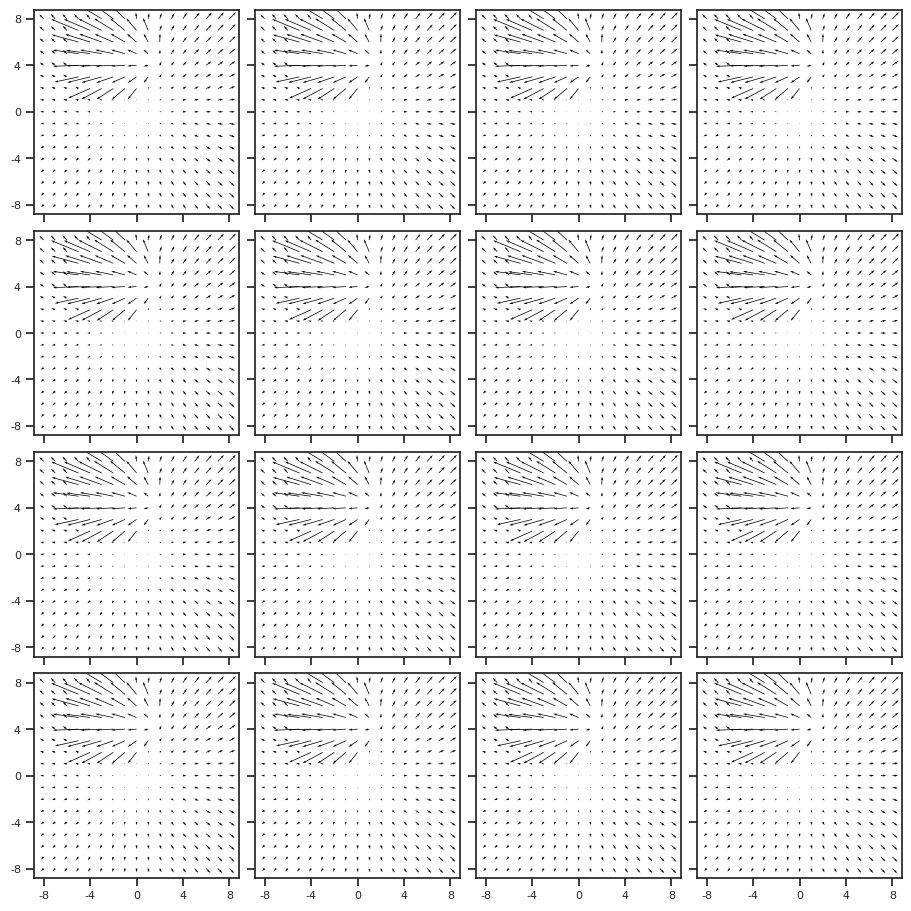

In [21]:
x_trav = tr.model.generate(z_trav)
fig, _ = show_opticflow(x_trav)

In [ ]:
"""
n_sd = 5

for i in range(tr.model.cfg.total_latents()):
    linspan = torch.linspace(
        start=zmu[i]-n_sd*zsd[i],
        end=zmu[i]+n_sd*zsd[i],
        steps=n,
    ).unsqueeze(-1).unsqueeze(-1)

    z_trav = [
        torch.repeat_interleave(
            input=e[[sample_i]],
            repeats=n,
            dim=0,
        ) for e in z
    ]
    group_i, latent_i = i // nz, i % nz
    z_trav[group_i][:, latent_i] = tr.to(linspan)
    x_trav = tr.model.generate(z_trav)
    print(i)
    fig, _ = show_opticflow(x_trav)
"""

## Load mi, identify latent

In [6]:
g, g_tst, select_i, select_lbl = prep_rofl(
    labels=list(LBL2TEX) + ['slf_v_norm', 'slf_v_theta', 'slf_v_phi'])
g.shape

(75000, 14)

In [7]:
%%time

z = tr.forward('vld', True)[0]['z']
z_tst = tr.forward('tst', True)[0]['z']

CPU times: user 6h 51min 4s, sys: 2min 4s, total: 6h 53min 8s
Wall time: 16min 46s


In [8]:
r = 1 - sp_dist.cdist(
    np.concatenate([z, z_tst]).T,
    np.concatenate([g, g_tst]).T,
    metric='correlation',
)
r.shape

(490, 14)

In [9]:
np.min(r), np.max(r)

(-0.9421805592214101, 0.8938340402413388)

In [10]:
row_ind, col_ind = sp_optim.linear_sum_assignment(
    cost_matrix=np.abs(r), maximize=True)
row_ind.shape, col_ind.shape

((14,), (14,))

In [11]:
plt.imshow(r[row_ind][:, col_ind])
plt.colorbar();

In [12]:
np.diag(r[row_ind][:, col_ind])

array([ 0.79168969,  0.65973407, -0.65414471,  0.82598617, -0.75276706,
        0.71691408,  0.77654887, -0.63550988, -0.94218056, -0.62643789,
       -0.87713688, -0.79640841,  0.78997454, -0.71661869])

In [14]:
best_latents = {select_lbl[i]: j for i, j in zip(col_ind, row_ind)}
best_latents = {lbl: best_latents.get(lbl) for lbl in select_lbl}
print(best_latents)

{
    'fix_x': 298,
    'fix_y': 340,
    'slf_v_x': 411,
    'slf_v_y': 271,
    'slf_v_z': 264,
    'obj0_alpha_x': 74,
    'obj0_alpha_y': 51,
    'obj0_size': 16,
    'obj0_v_x': 356,
    'obj0_v_y': 211,
    'obj0_v_z': 221,
    'slf_v_norm': 440,
    'slf_v_theta': 285,
    'slf_v_phi': 299
}

In [43]:
j = best_latents['fix_x']

In [44]:
fig, ax = create_figure(1, 1, (9, 3))
ax.plot(r[j])
ax.tick_params(axis='x', rotation=-90)
ax.set(
    xticks=range(len(select_lbl)),
    xticklabels=select_lbl,
)
ax.grid()
plt.show()

In [17]:
%%time

mi = mi_analysis(
    z=np.concatenate([z, z_tst]),
    g=np.concatenate([g, g_tst]),
)

CPU times: user 33.5 s, sys: 17.5 s, total: 50.9 s
Wall time: 18min 36s


In [63]:
mi['mi_norm'].shape

(14, 490)

In [64]:
idx = 11
np.argsort(mi['mi'][idx])[::-1][:5], np.argsort(mi['mi_norm'][idx])[::-1][:5]

(array([202, 278, 411, 416, 271]), array([202, 440, 278, 411, 416]))

In [65]:
best_i = np.argmax(mi['mi'][idx])
best_i, select_lbl[idx]

(202, 'slf_v_norm')

In [66]:
mi['mi'][idx, best_i]

0.6844208418121003

In [67]:
np.argsort(mi['mi'][idx])[-2:]

array([278, 202])

In [68]:
l2t = {
    'fix_x': r'$F_x$',
    'fix_y': r'$F_y$',
    'slf_v_norm': r'$\rho$',
    'slf_v_theta': r'$\theta$',
    'slf_v_phi': r'$\phi$',
    'slf_v_x': r'$V_{self, x}$',
    'slf_v_y': r'$V_{self, y}$',
    'slf_v_z': r'$V_{self, z}$',
    'obj0_alpha_x': r'$X_{obj}$',
    'obj0_alpha_y': r'$Y_{obj}$',
    'obj0_size': r'$S_{obj}$',
    'obj0_v_x': r'$V_{obj, x}$',
    'obj0_v_y': r'$V_{obj, y}$',
    'obj0_v_z': r'$V_{obj, z}$',
}

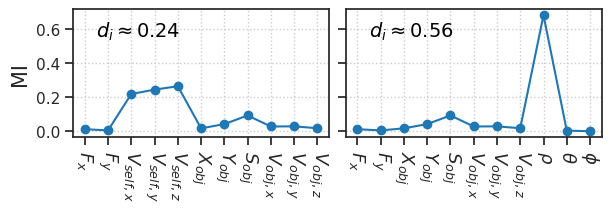

In [72]:
fig, axes = create_figure(1, 2, (6, 2), sharey='row', layout='constrained')
for i in range(2):
    if i == 0:
        exclude = ['slf_v_norm', 'slf_v_theta', 'slf_v_phi']
    else:
        exclude = ['slf_v_x', 'slf_v_y', 'slf_v_z']
    inds = [
        i for i, lbl in
        enumerate(select_lbl)
        if lbl not in exclude
    ]
    
    x2p = mi['mi'][:, best_i][inds]
    d = 1 - entropy_normalized(x2p / sum(x2p))
    axes[i].plot(x2p, marker='o')
    axes[i].tick_params(axis='x', rotation=-90, labelsize=13)
    axes[i].set(
        xticks=range(len(inds)),
        xticklabels=[l2t[select_lbl[i]] for i in inds],
    )
    axes[i].annotate(
        text=r"$d_i \approx $" + f"{d:0.2f}",
        xy=(0.09, 0.78),
        xycoords='axes fraction',
        color='k',
        fontsize=14,
    )
    axes[i].grid()
axes[0].set_ylabel('MI', fontsize=15)
plt.show()

In [27]:
# fig.savefig(pjoin(fig_base_dir, 'polar2cart_mi.pdf'), **kws_fig)

In [73]:
z_both = np.concatenate([z, z_tst])
g_both = np.concatenate([g, g_tst])

z_both.shape, g_both.shape

((150000, 490), (150000, 14))

In [74]:
label_lists = {
    'carte': ['slf_v_x', 'slf_v_y', 'slf_v_z'],
    'polar': ['slf_v_norm', 'slf_v_theta', 'slf_v_phi'],
}
_y = z_both[:, best_i]
_y = sp_stats.zscore(_y)

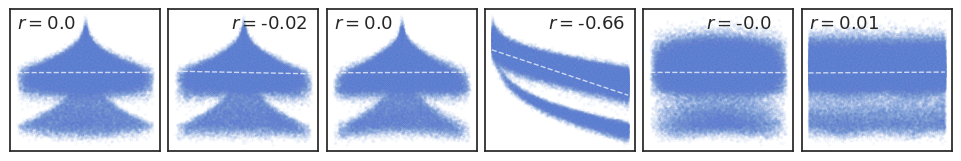

In [75]:
fig, axes = create_figure(1, 6, (9.5, 1.5), sharey='all', layout='constrained')

ii = 0
for k, v in label_lists.items():
    for lbl in v:
        i = select_lbl.index(lbl)
        _x = g_both[:, i]
        # lin regress
        lr = sp_stats.linregress(_x, _y)
        x_min = _x.min()
        x_max = _x.max()
        xs = np.linspace(x_min, x_max, 1000)
        ys = lr.slope * xs + lr.intercept
        sns.scatterplot(
            x=_x,
            y=_y,
            s=5,
            alpha=0.05,
            # bins=20,
            color=get_palette()[0]['cNVAE'],
            ax=axes[ii],
        )
        axes[ii].plot(xs, ys, color='white', ls='--', lw=1.0, alpha=0.7)
        axes[ii].annotate(
            text=r'$r = $' + str(np.round(lr.rvalue, 2)),
            xy=(0.05 if lr.rvalue > 0 else 0.42, 0.865),
            xycoords='axes fraction',
            fontsize=13,
        )
        ii += 1
remove_ticks(axes, False)
plt.show()

In [76]:
for k, v in label_lists.items():
    for lbl in v:
        i = select_lbl.index(lbl)
        r, _ = sp_stats.pearsonr(g_both[:, i], z_both[:, best_i])
        print(f"{lbl}:\tr = {r:0.2f}")

slf_v_x:        r = 0.00

slf_v_y:        r = -0.02

slf_v_z:        r = 0.00

slf_v_norm:     r = -0.66

slf_v_theta:    r = -0.00

slf_v_phi:      r = 0.01

## Traversal

In [77]:
x, _ = next(iter(tr.dl_trn))

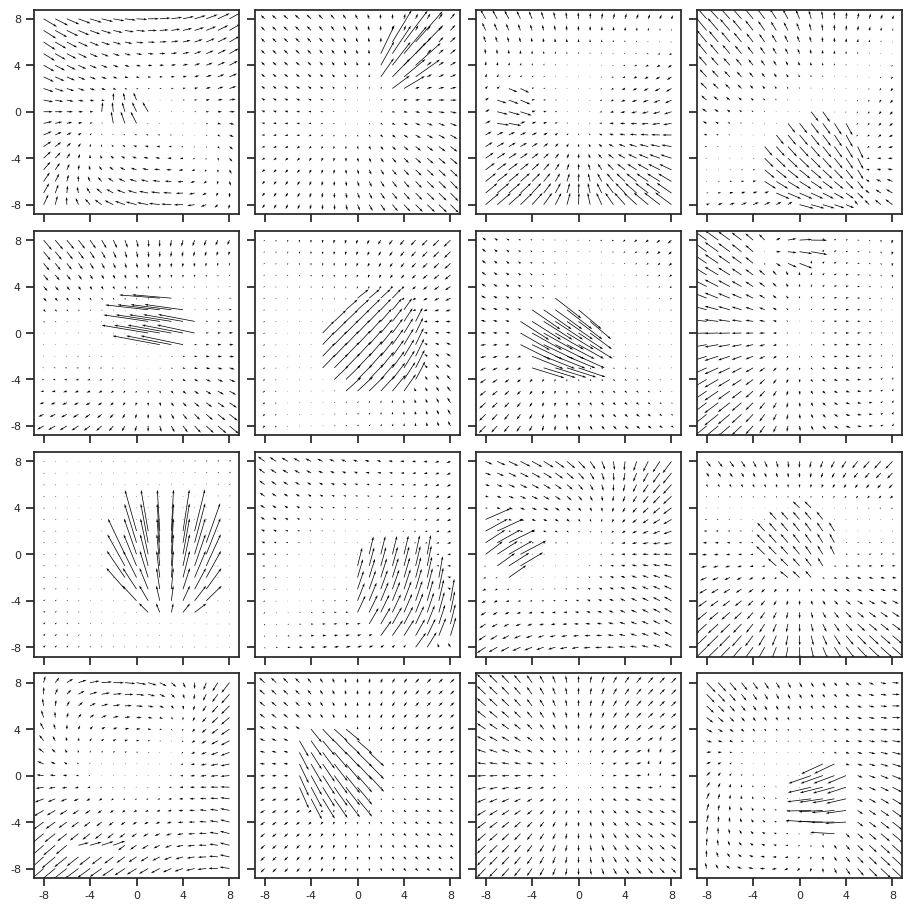

In [78]:
fig, _ = show_opticflow(x)

In [7]:
# fig.savefig(pjoin(fig_base_dir, 'samples_fixate1.pdf'), **kws_fig)

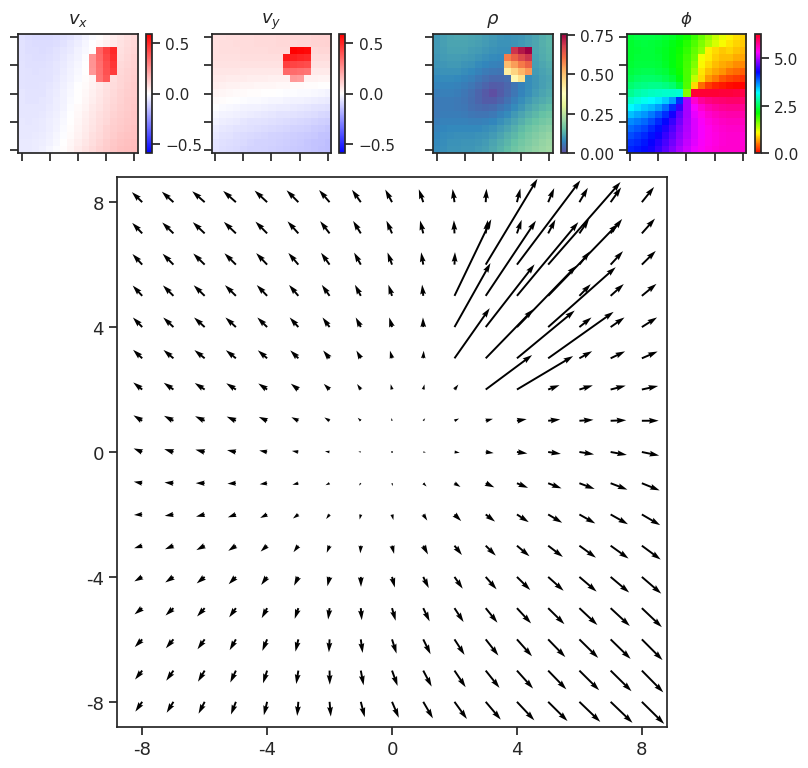

In [79]:
which_sample = 1
show_opticflow_full(x[which_sample]);

In [80]:
with torch.no_grad():
    x_hat, z, q, p = tr.model(x)

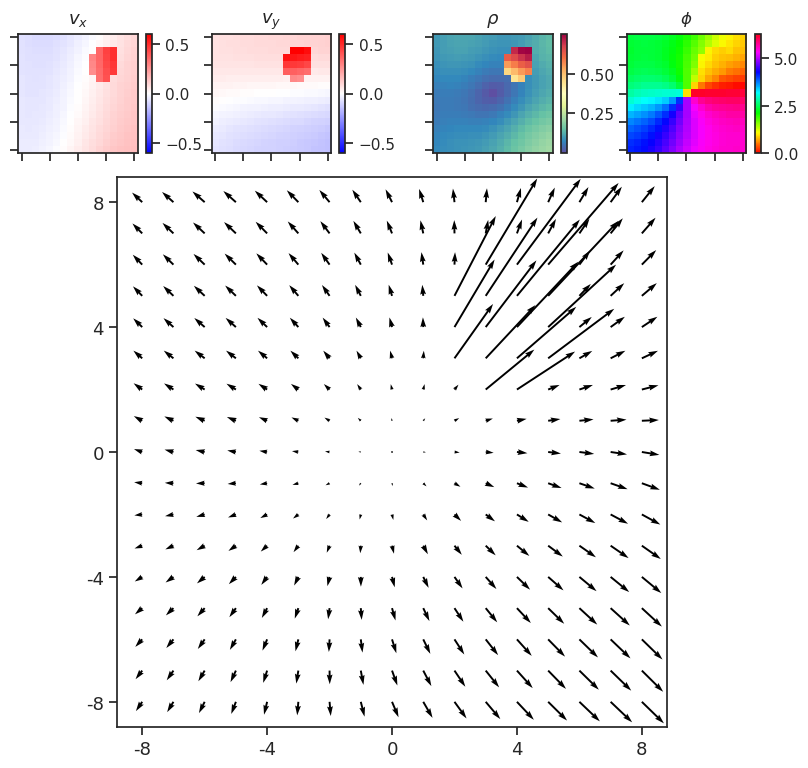

In [81]:
show_opticflow_full(x_hat[which_sample]);

In [358]:
# z = torch.cat(z, dim=1).squeeze()

## N groups

In [133]:
nz = tr.model.cfg.n_latent_per_group
n_groups = sum(tr.model.cfg.groups)
nz, n_groups, nz * n_groups

(14, 35, 490)

## Obj_y

In [134]:
with torch.no_grad():
    x_hat, z, q, p = tr.model(x)

In [135]:
idx = 6
idx, select_lbl[idx]

(6, 'obj0_alpha_y')

In [136]:
best_i = np.argsort(mi['mi'][idx])[-1]
best_i

85

In [141]:
which_group, which_latent = best_i // nz, best_i % nz
which_group, which_latent

(6, 1)

In [143]:
mu = q[which_group].mu[which_sample, which_latent].squeeze()
sig = q[which_group].sigma[which_sample, which_latent].squeeze()
mu, sig

(tensor(-0.4698), tensor(0.7107))

In [144]:
z[which_group][which_sample, which_latent].squeeze()

tensor(0.3992)

In [145]:
num = 8
z_trav = z.copy()
z_trav = [torch.repeat_interleave(e[[which_sample]], num, dim=0) for e in z_trav]
z_trav[which_group][:, which_latent] = torch.linspace(
    mu - 5 * sig, mu + 5 * sig, num).unsqueeze(-1).unsqueeze(-1)

In [146]:
z_trav[which_group][:, which_latent].squeeze()

tensor([-4.0232, -3.0079, -1.9927, -0.9774,  0.0379,  1.0531,  2.0684,  3.0836])

In [147]:
from vae.vae2d import CombinerDec, Normal

In [148]:
with torch.no_grad():
    idx = 0
    s = tr.model.prior_ftr0.unsqueeze(0)
    s = s.expand(z_trav[idx].size(0), -1, -1, -1)
    for cell in tr.model.dec_tower:
        if isinstance(cell, CombinerDec):
            s = cell(s, tr.model.expand[idx](z_trav[idx]))
            idx += 1
        else:
            s = cell(s)

    for cell in tr.model.post_process:
        s = cell(s)
    x_gen = tr.model.out(s)

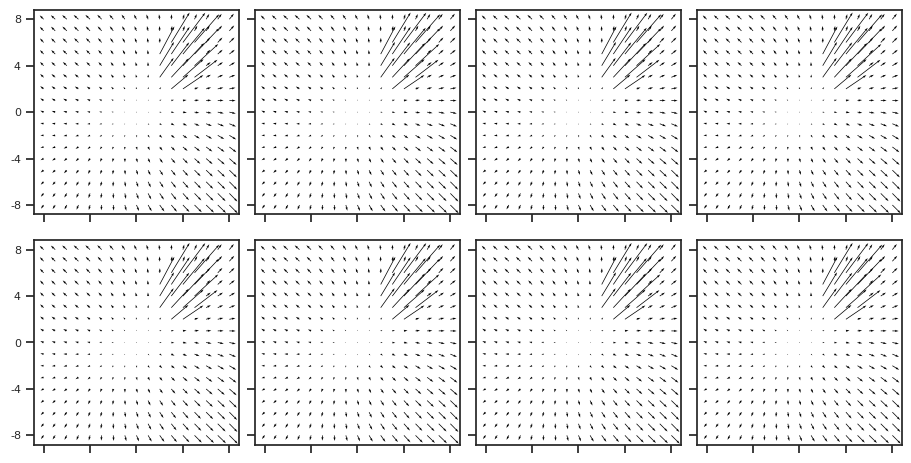

In [149]:
show_opticflow(x_gen);

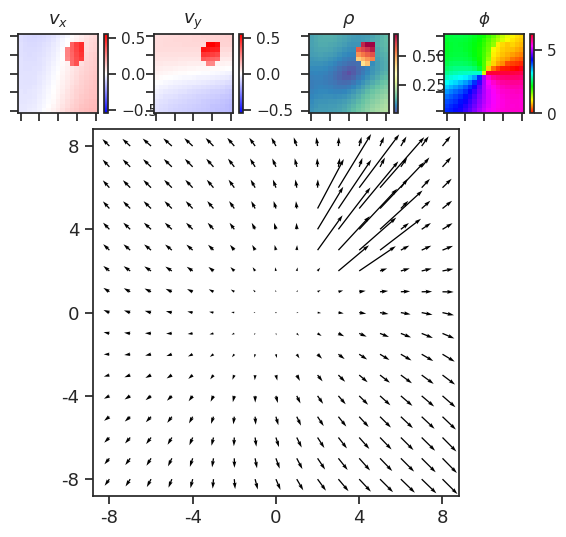

In [150]:
show_opticflow_full(x_gen[0], figsize=(7, 6));

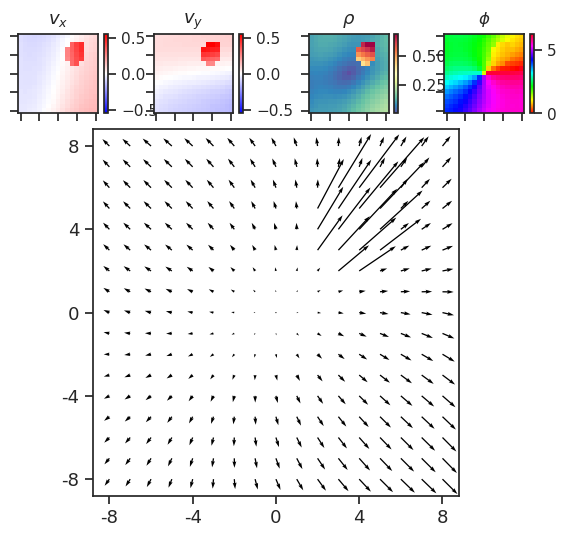

In [151]:
show_opticflow_full(x_gen[-1], figsize=(7, 6));

## Obj_x

In [176]:
with torch.no_grad():
    x_hat, z, q, p = tr.model(x)

In [177]:
idx = 5
idx, select_lbl[idx]

(5, 'obj0_alpha_x')

In [178]:
best_i = np.argsort(mi['mi'][idx])[-1]
best_i

203

In [179]:
which_group, which_latent = best_i // nz, best_i % nz
which_group, which_latent

(14, 7)

In [180]:
mu = q[which_group].mu[which_sample, which_latent].squeeze()
sig = q[which_group].sigma[which_sample, which_latent].squeeze()
mu, sig

(tensor(-8.5291), tensor(0.0917))

In [181]:
z[which_group][which_sample, which_latent].squeeze()

tensor(-8.4984)

In [182]:
num = 8
z_trav = z.copy()
z_trav = [torch.repeat_interleave(e[[which_sample]], num, dim=0) for e in z_trav]
z_trav[which_group][:, which_latent] = torch.linspace(
    mu - 3 * sig, mu + 3 * sig, num).unsqueeze(-1).unsqueeze(-1)

In [183]:
z_trav[which_group][:, which_latent].squeeze()

tensor([-8.8042, -8.7256, -8.6470, -8.5684, -8.4898, -8.4112, -8.3326, -8.2540])

In [184]:
from vae.vae2d import CombinerDec, Normal

In [185]:
with torch.no_grad():
    idx = 0
    s = tr.model.prior_ftr0.unsqueeze(0)
    s = s.expand(z_trav[idx].size(0), -1, -1, -1)
    for cell in tr.model.dec_tower:
        if isinstance(cell, CombinerDec):
            s = cell(s, tr.model.expand[idx](z_trav[idx]))
            idx += 1
        else:
            s = cell(s)

    for cell in tr.model.post_process:
        s = cell(s)
    x_gen = tr.model.out(s)

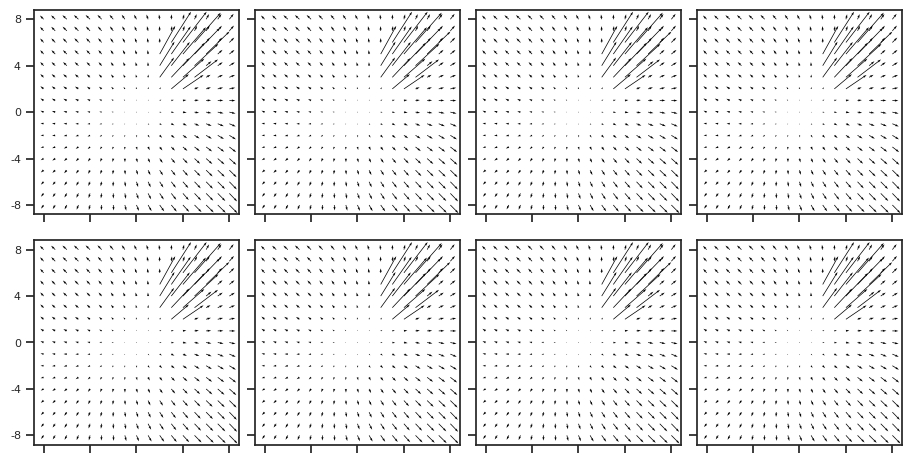

In [186]:
show_opticflow(x_gen);

## Obj_size

In [187]:
with torch.no_grad():
    x_hat, z, q, p = tr.model(x)

In [188]:
idx = 7
idx, select_lbl[idx]

(7, 'obj0_size')

In [189]:
best_i = np.argsort(mi['mi'][idx])[-1]
best_i

16

In [190]:
which_group, which_latent = best_i // nz, best_i % nz
which_group, which_latent

(1, 2)

In [191]:
mu = q[which_group].mu[which_sample, which_latent].squeeze()
sig = q[which_group].sigma[which_sample, which_latent].squeeze()
mu, sig

(tensor(-2.1551), tensor(0.0937))

In [192]:
z[which_group][which_sample, which_latent].squeeze()

tensor(-2.1593)

In [193]:
num = 8
z_trav = z.copy()
z_trav = [torch.repeat_interleave(e[[which_sample]], num, dim=0) for e in z_trav]
z_trav[which_group][:, which_latent] = torch.linspace(
    mu - 3 * sig, mu + 3 * sig, num).unsqueeze(-1).unsqueeze(-1)

In [194]:
z_trav[which_group][:, which_latent].squeeze()

tensor([-2.4364, -2.3560, -2.2757, -2.1953, -2.1150, -2.0346, -1.9543, -1.8739])

In [195]:
from vae.vae2d import CombinerDec, Normal

In [196]:
with torch.no_grad():
    idx = 0
    s = tr.model.prior_ftr0.unsqueeze(0)
    s = s.expand(z_trav[idx].size(0), -1, -1, -1)
    for cell in tr.model.dec_tower:
        if isinstance(cell, CombinerDec):
            s = cell(s, tr.model.expand[idx](z_trav[idx]))
            idx += 1
        else:
            s = cell(s)

    for cell in tr.model.post_process:
        s = cell(s)
    x_gen = tr.model.out(s)

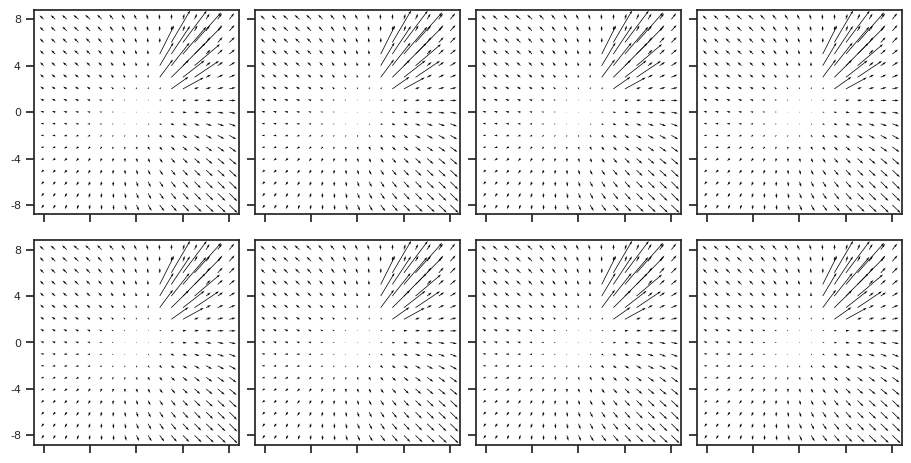

In [197]:
show_opticflow(x_gen);

## Self norm

In [198]:
with torch.no_grad():
    x_hat, z, q, p = tr.model(x)

In [199]:
idx = 11
idx, select_lbl[idx]

(11, 'slf_v_norm')

In [200]:
best_i = np.argsort(mi['mi'][idx])[-1]
best_i

202

In [201]:
which_group, which_latent = best_i // nz, best_i % nz
which_group, which_latent

(14, 6)

In [202]:
mu = q[which_group].mu[which_sample, which_latent].squeeze()
sig = q[which_group].sigma[which_sample, which_latent].squeeze()
mu, sig

(tensor(-2.8928), tensor(1.7264))

In [203]:
z[which_group][which_sample, which_latent].squeeze()

tensor(-4.8301)

In [204]:
num = 8
z_trav = z.copy()
z_trav = [torch.repeat_interleave(e[[which_sample]], num, dim=0) for e in z_trav]
z_trav[which_group][:, which_latent] = torch.linspace(
    mu - 3 * sig, mu + 3 * sig, num).unsqueeze(-1).unsqueeze(-1)

In [205]:
z_trav[which_group][:, which_latent].squeeze()

tensor([-8.0719, -6.5921, -5.1124, -3.6326, -2.1529, -0.6731,  0.8066,  2.2864])

In [206]:
from vae.vae2d import CombinerDec, Normal

In [207]:
with torch.no_grad():
    idx = 0
    s = tr.model.prior_ftr0.unsqueeze(0)
    s = s.expand(z_trav[idx].size(0), -1, -1, -1)
    for cell in tr.model.dec_tower:
        if isinstance(cell, CombinerDec):
            s = cell(s, tr.model.expand[idx](z_trav[idx]))
            idx += 1
        else:
            s = cell(s)

    for cell in tr.model.post_process:
        s = cell(s)
    x_gen = tr.model.out(s)

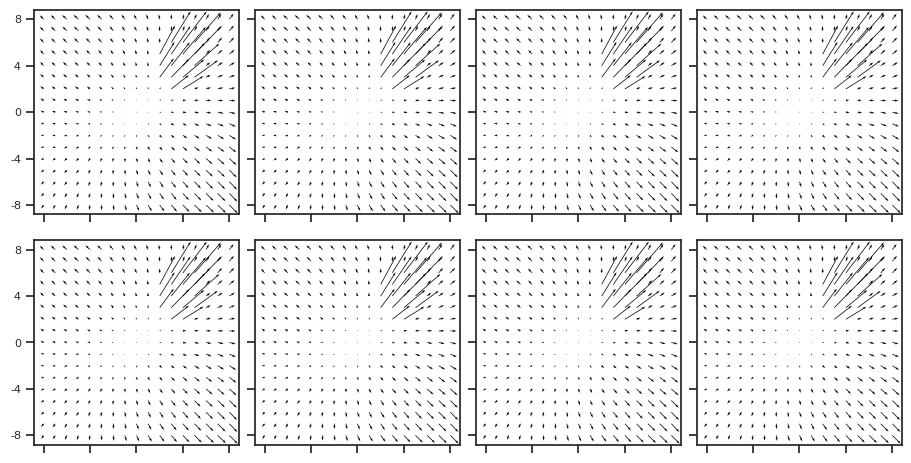

In [208]:
show_opticflow(x_gen);

## Final, generate

In [209]:
with torch.no_grad():
    x_hat, z, q, p = tr.model(x)

In [211]:
select_lbl[6]

'obj0_alpha_y'

In [212]:
best_i = np.argsort(mi['mi'][6])[-1]
best_i

85

In [214]:
which_group, which_latent = best_i // 14, best_i % 14
which_group, which_latent

(6, 1)

In [215]:
which_sample = 11

In [216]:
mu = q[which_group].mu[which_sample, which_latent].squeeze()
sig = q[which_group].sigma[which_sample, which_latent].squeeze()
mu, sig

(tensor(0.4096), tensor(0.8482))

In [217]:
z[which_group][which_sample, which_latent].squeeze()

tensor(1.4538)

In [218]:
use_this = torch.linspace(mu - 6 * sig, mu + 3 * sig, num).unsqueeze(-1).unsqueeze(-1)

In [219]:
num = 7
z_trav = z.copy()
z_trav = [torch.repeat_interleave(e[[which_sample]], num, dim=0) for e in z_trav]
z_trav[which_group][:, which_latent] = use_this

RuntimeError: The expanded size of the tensor (7) must match the existing size (8) at non-singleton dimension 0.  Target sizes: [7, 1, 1].  Tensor sizes: [8, 1, 1]

In [718]:
z_trav[which_group][:, which_latent].squeeze()

tensor([-2.5185, -1.8464, -1.1742, -0.5021,  0.1701,  0.8422,  1.5144],
       device='cuda:0')

In [719]:
with torch.no_grad():
    idx = 0
    s = self.prior_ftr0.unsqueeze(0)
    s = s.expand(z_trav[idx].size(0), -1, -1, -1)
    for cell in self.dec_tower:
        if isinstance(cell, CombinerDec):
            s = cell(s, self.expand[idx](z_trav[idx]))
            idx += 1
        else:
            s = cell(s)

    for cell in self.post_process:
        s = cell(s)
    x_gen = self.out(s)

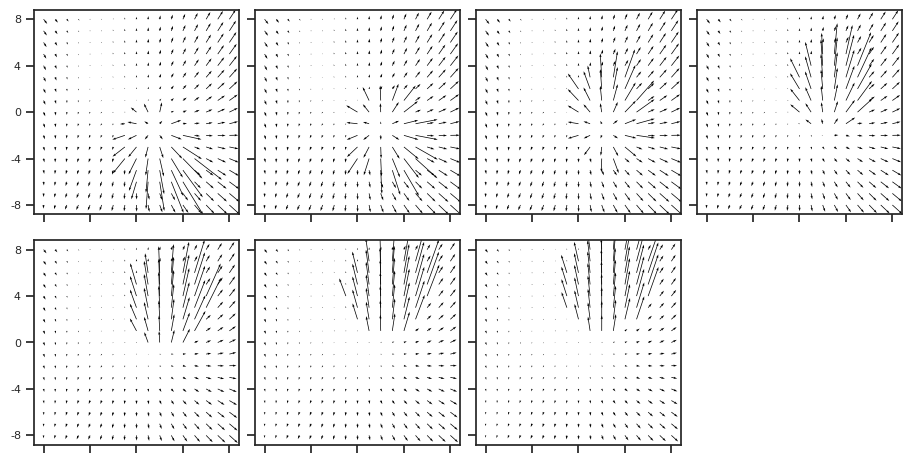

In [720]:
show_opticflow(x_gen);

In [730]:
num = 7
x_gen_all = []
for i in range(num+2):
    which_sample = i + 11
    z_trav = z.copy()
    z_trav = [torch.repeat_interleave(e[[which_sample]], num, dim=0) for e in z_trav]
    z_trav[which_group][:, which_latent] = use_this
    
    with torch.no_grad():
        idx = 0
        s = self.prior_ftr0.unsqueeze(0)
        s = s.expand(z_trav[idx].size(0), -1, -1, -1)
        for cell in self.dec_tower:
            if isinstance(cell, CombinerDec):
                s = cell(s, self.expand[idx](z_trav[idx]))
                idx += 1
            else:
                s = cell(s)

        for cell in self.post_process:
            s = cell(s)
        x_gen = self.out(s)
        x_gen_all.append(x_gen)

In [731]:
x_gen_all = torch.stack(x_gen_all)
x_gen_all.shape

torch.Size([9, 7, 2, 17, 17])

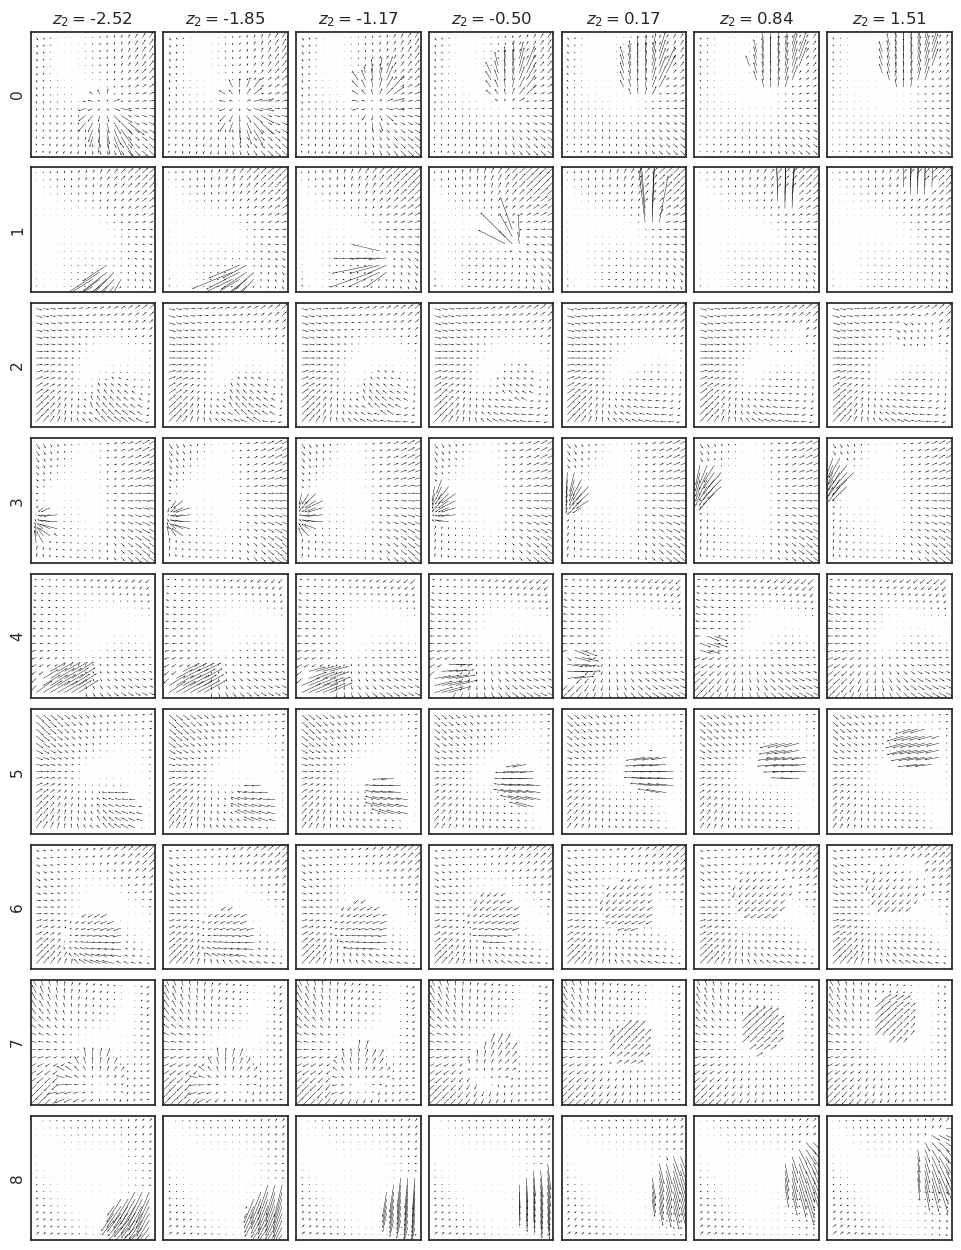

In [754]:
fig, axes = show_opticflow_row(x_gen_all, figsize=(9.5, 12.4), display=False)
for i in range(7):
    axes[0, i].set_title(r"$z_2 = $" + f"{to_np(use_this)[i].item():0.2f}", fontsize=12)
for j in range(9):
    axes[j, 0].set_ylabel(f"{j}", fontsize=11)
display(fig)

In [755]:
fig.savefig(pjoin(fig_base_dir, 'traverse_objy.pdf'), **kws_fig)